# Feature Map - ALE

Below is the code used for analysing ALE scores.

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import os

# import data class
from utilities.dataset_utils import DiabetesData

from qiskit_machine_learning.algorithms import QSVC

# explainability imports
# ale
from skexplain.main.explain_toolkit import ExplainToolkit

# state fidelity
from qiskit.quantum_info import state_fidelity

# qiskit imports
# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

Dataset loading - change code hear to analyze different dataset

**N.B.** works only for binary classification datasets

In [2]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [3]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', '..', 'models', 'qml-simulator', 'qsvc_best_params.model')

qsvc = QSVC.load(path)

In [4]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

In [5]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [6]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [7]:
# sampler
sampler = Sampler.from_backend(backend)

### Feature Map Explainability

Feature map implementation - change here to analyze different feature map

In [8]:
# generate feature map used
feature_map = qsvc.quantum_kernel.feature_map

In [9]:
print(feature_map.name)
print(feature_map.num_qubits)

ZFeatureMap
8


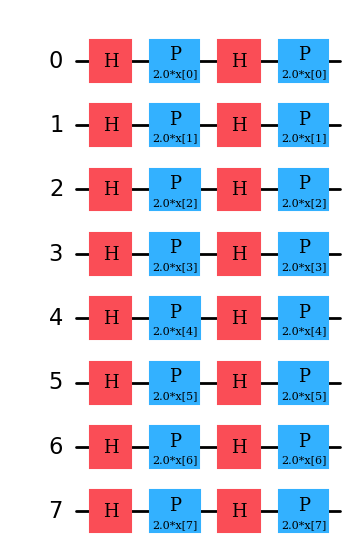

In [10]:
feature_map.draw('mpl')

```python
get_quantum_state
```
This function assigns the parameters of the feature map to that of the input classical data vector. It saves the quantum statevector when this circuit is executed.


In [11]:
# function to get quantum state
def get_quantum_state(x):
    """
    Gets quantum state of a given data point
    """
    # copy circuit
    qc = feature_map.copy()
    
    # param dict
    params = dict(zip(qc.parameters, x))
    
    # assign params to circuit
    qc = qc.assign_parameters(params)
    
    # save statevector
    qc.save_statevector()
    
    # run on statevector simulator
    result = backend.run(qc).result()
    return result.get_statevector()

```python
state_similarity
```
Measures the state fidelity between two quantum states. Fidelity is expressed as:
$$F=| \langle \psi | \phi \rangle |^2 $$

where $|\psi\rangle$ is the actual state and $|\phi\rangle$ is the target state. A fidelity of 1 indicates identical states while 0 indicates orthogonal states (different).

In [12]:
# function to calculate fidelity between two data points
def state_similarity(x1, x2):
    """
    Measures similarity between two states
    """
    # get quantum states for 2 data points
    state1 = get_quantum_state(x1)
    state2 = get_quantum_state(x2)
    
    # calculate state fidelity
    fidelity = np.abs(state_fidelity(state1, state2))
    return fidelity

In [13]:
class QuantumSimilarity:
    def __init__(self, x_sample):
        """
        Encapsulate as class to be compatible with ExplainToolkit
        """
        self.x_sample = x_sample

    def predict(self, X):
        """
        For each input sample in X compute the quantum state similarity with the fixed reference sample
        """
        return np.array([state_similarity(x_i, self.x_sample) for x_i in X])

```python
quantum_state_encoding_ale
```
Computes ALE for feature map. Measures how perturbing each feature affects encoded quantum state by comparing the state fidelity against a fixed reference state.

In [ ]:
def quantum_state_encoding_ale(feature_map, x_sample, background_data, feature_names=None, n_bins=20):
    """
    Calculate ALE for the feature map and visualize the ALE curves
    
    Args:
        feature_map: feature map circuit
        x_sample: 1D numpy array representing the sample to explain
        background_data: 2D numpy array of background samples
        feature_names: feature name list
        n_bins: number of bins to compute the ALE (default=20)
    """
    # model init
    qs_model = QuantumSimilarity(x_sample)
    
    explainer = ExplainToolkit(
        estimators=[("Quantum Similarity Model", qs_model)],
        X=background_data,
        feature_names=feature_names
    )
    
    for feature in feature_names:
        # compute the ALE only for the current feature
        ale_feature = explainer.ale(features=[feature], n_bins=n_bins)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # plot ale
        explainer.plot_ale(
            ale=ale_feature,
            features=[feature],
            display_feature_names={feature: feature},
            ax=ax,
            fontsize=12
        )
        
        ax.set_title(f"ALE Plot for {feature}", fontsize=16)
        plt.tight_layout()
        plt.show()

ALE Numerical Features: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


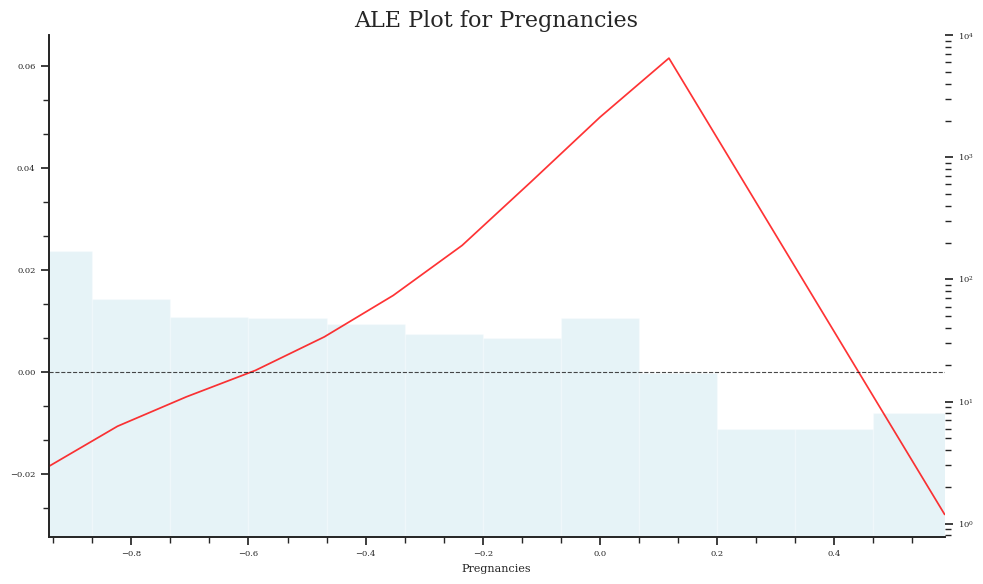

ALE Numerical Features: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


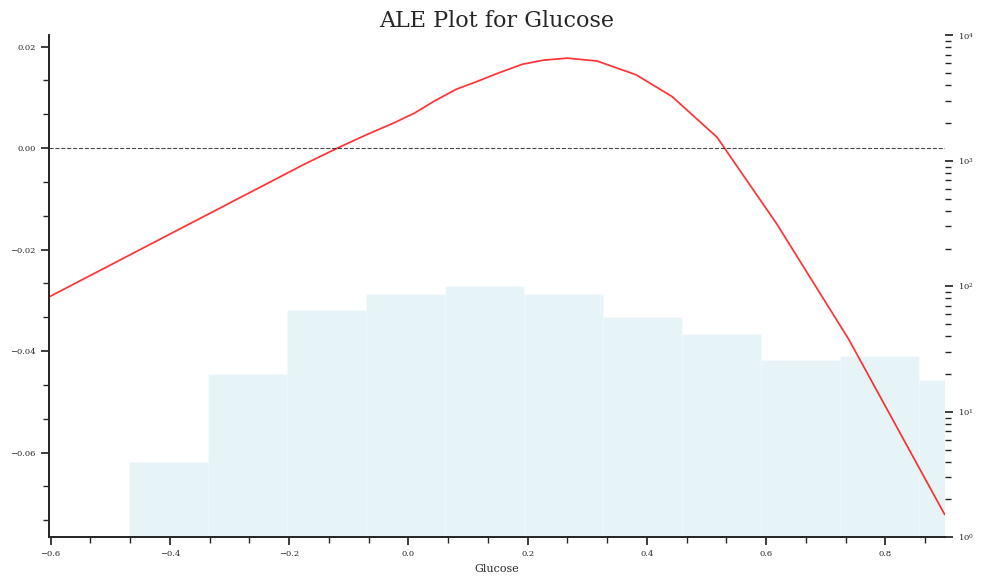

ALE Numerical Features: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


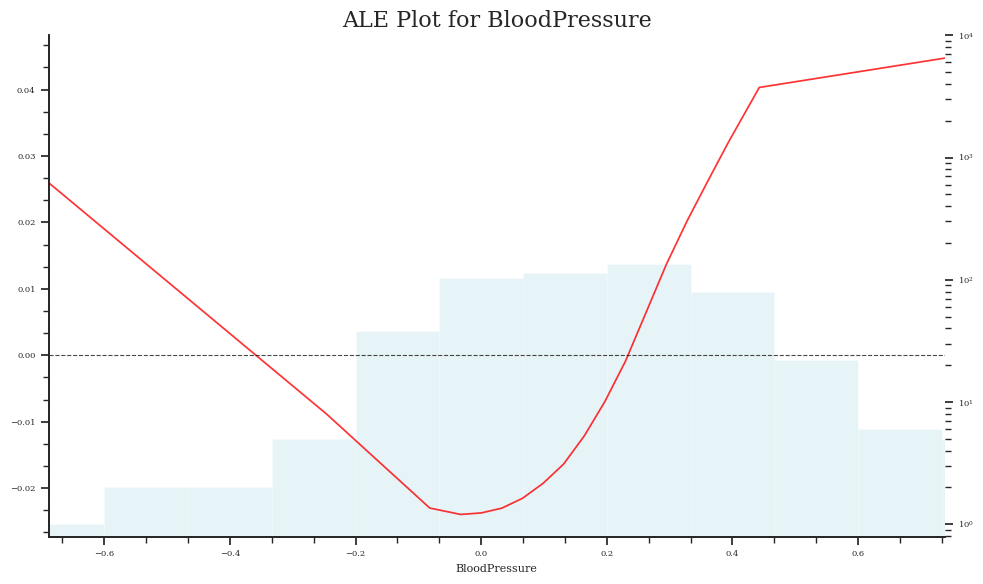

ALE Numerical Features: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


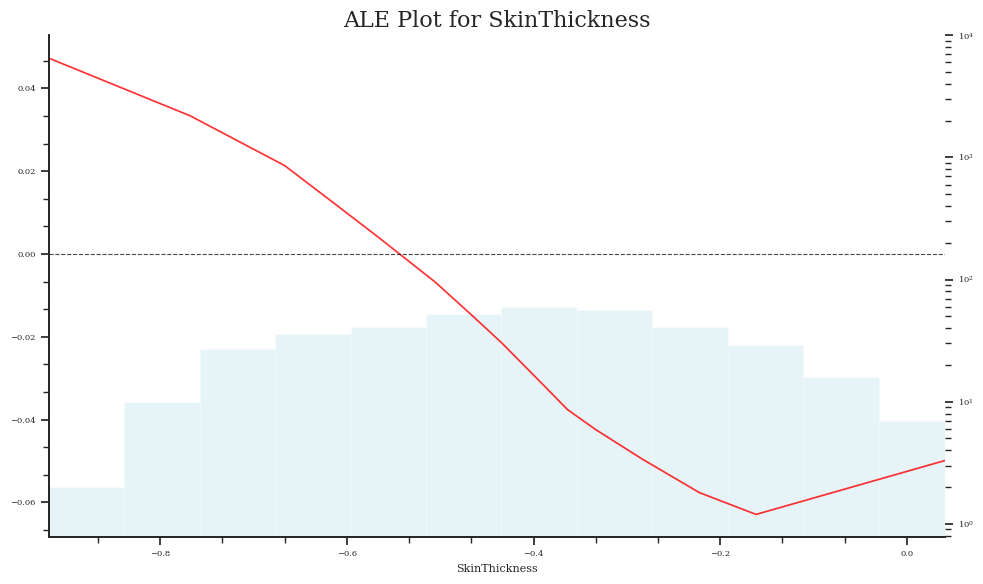

ALE Numerical Features: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


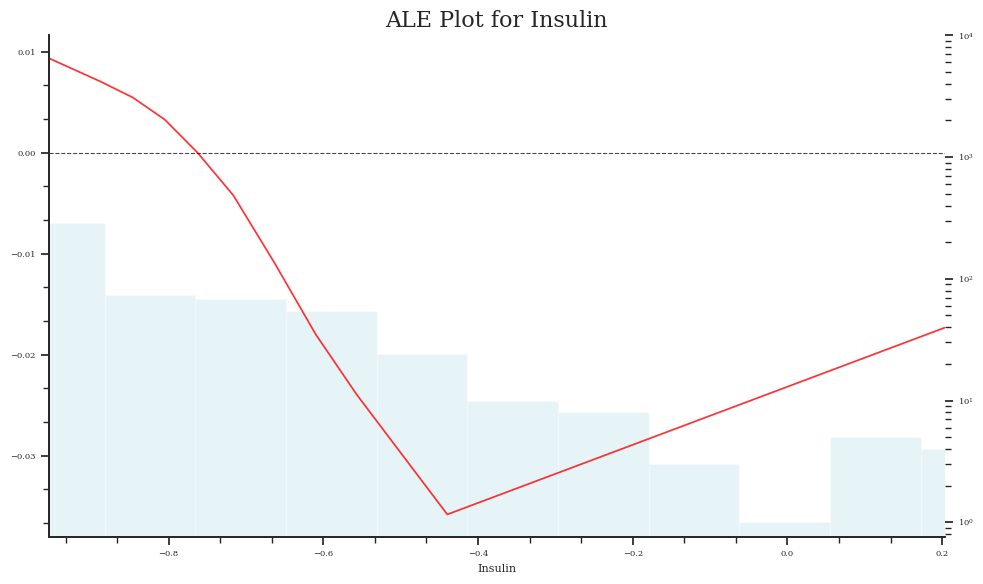

ALE Numerical Features: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


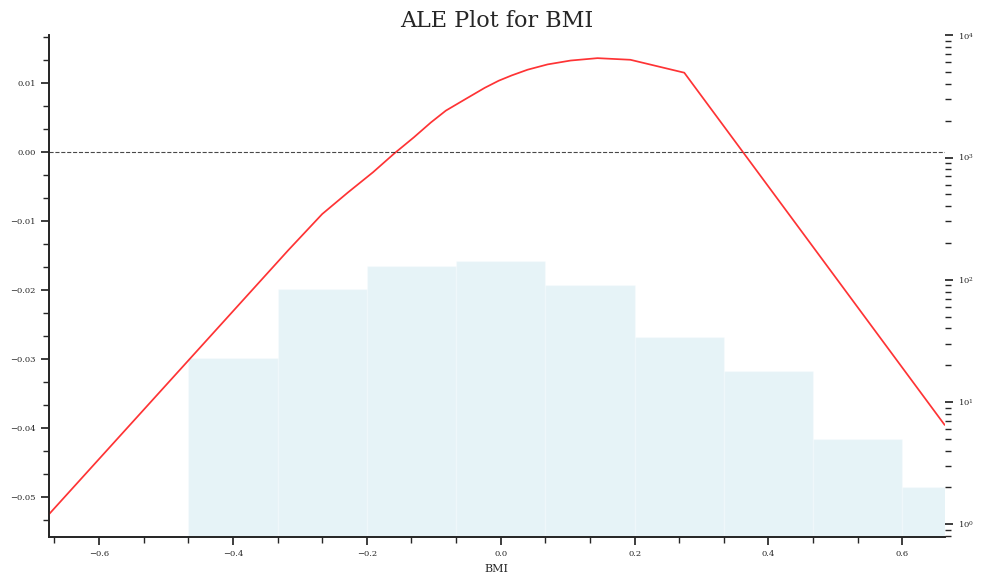

ALE Numerical Features: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


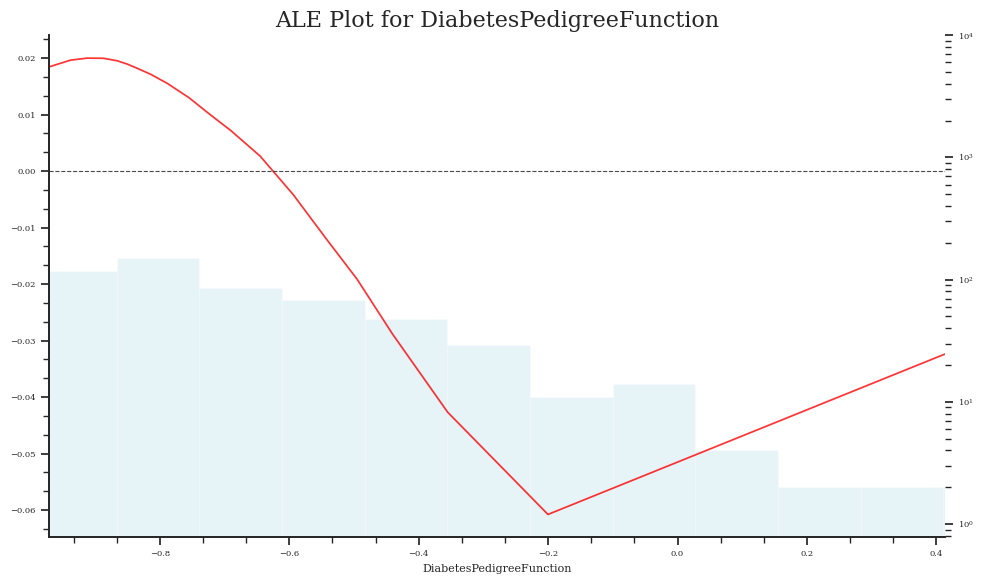

ALE Numerical Features: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


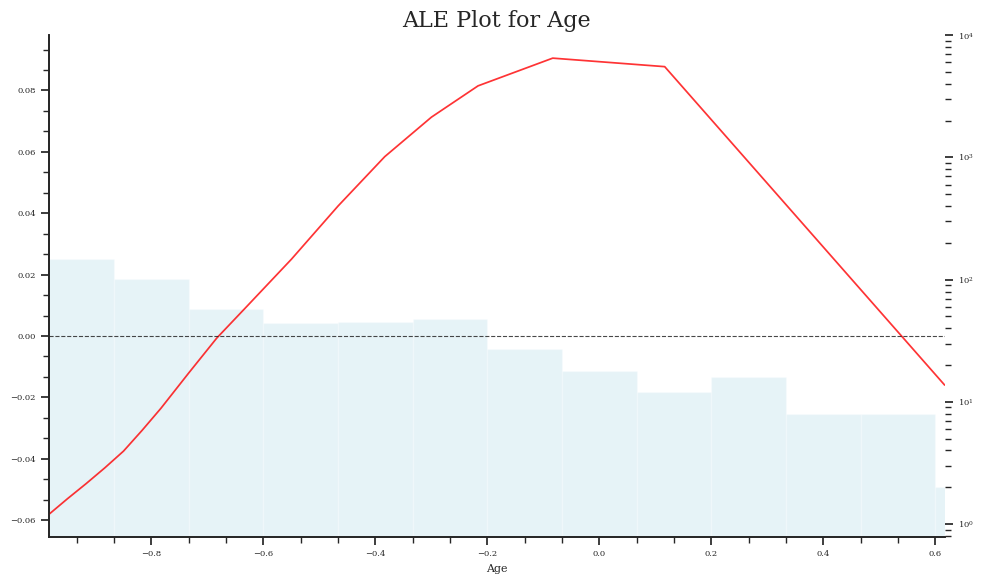

In [15]:
# select sample
sample_idx = 150

x_sample = X_test[sample_idx]
background_data = X_train

ds = quantum_state_encoding_ale(feature_map, x_sample, background_data, feature_names)

Positive slope -> increasing value tends to increase similarity

Negative slope -> decreasing value tends to decrease similarity

Slope steepness -> how much certain value affects prediciton at different points

Basically higher ALE values, means that at the corresponding feature values, the quantum state is more sensitive.

